### Questions :
1. Data cleaning and preprocessing
1. What's the distribution of Serious , slight and all accidents in relation to the day of the Week.
2. Motorcycle accidents
3. Number of accidents grouped by the time of the day
4. Weather condictions in relation to fatal accidents
6. Accidents on the map 

In [1]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession, Window, Row
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
spark = SparkSession \
    .builder \
    .appName("Bundesliga") \
    .getOrCreate()

In [3]:
def load_dataframe(filename):
    df=spark.read.format('csv').options(header='true').load(filename)
    return df

df = load_dataframe('../data/car_accidents/Accident_information.csv')
df.limit(5).toPandas()

,Accident_Index,1st_Road_Class,1st_Road_Number,2nd_Road_Class,2nd_Road_Number,Accident_Severity,Carriageway_Hazards,Date,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,...,Police_Force,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Year,InScotland
0,200501BS00001,A,3218,NA,0,Serious,None,2005-01-04,Tuesday,1,...,Metropolitan Police,Wet or damp,Single carriageway,None,30,17:42,Urban,Raining no high winds,2005,No
1,200501BS00002,B,450,C,0,Slight,None,2005-01-05,Wednesday,1,...,Metropolitan Police,Dry,Dual carriageway,None,30,17:36,Urban,Fine no high winds,2005,No
2,200501BS00003,C,0,NA,0,Slight,None,2005-01-06,Thursday,1,...,Metropolitan Police,Dry,Single carriageway,None,30,00:15,Urban,Fine no high winds,2005,No
3,200501BS00004,A,3220,NA,0,Slight,None,2005-01-07,Friday,1,...,Metropolitan Police,Dry,Single carriageway,None,30,10:35,Urban,Fine no high winds,2005,No
4,200501BS00005,Unclassified,0,NA,0,Slight,None,2005-01-10,Monday,1,...,Metropolitan Police,Wet or damp,Single carriageway,None,30,21:13,Urban,Fine no high winds,2005,No


In [4]:
df.columns

['Accident_Index',
 '1st_Road_Class',
 '1st_Road_Number',
 '2nd_Road_Class',
 '2nd_Road_Number',
 'Accident_Severity',
 'Carriageway_Hazards',
 'Date',
 'Day_of_Week',
 'Did_Police_Officer_Attend_Scene_of_Accident',
 'Junction_Control',
 'Junction_Detail',
 'Latitude',
 'Light_Conditions',
 'Local_Authority_(District)',
 'Local_Authority_(Highway)',
 'Location_Easting_OSGR',
 'Location_Northing_OSGR',
 'Longitude',
 'LSOA_of_Accident_Location',
 'Number_of_Casualties',
 'Number_of_Vehicles',
 'Pedestrian_Crossing-Human_Control',
 'Pedestrian_Crossing-Physical_Facilities',
 'Police_Force',
 'Road_Surface_Conditions',
 'Road_Type',
 'Special_Conditions_at_Site',
 'Speed_limit',
 'Time',
 'Urban_or_Rural_Area',
 'Weather_Conditions',
 'Year',
 'InScotland']

In [5]:
#choosing only the necessery columns (for now)
columns = ['Accident_Index','Accident_Severity','Date','Day_of_Week','Latitude','Longitude','Number_of_Casualties','Number_of_Vehicles','Time',
           'Weather_Conditions','Year',]
df_accidents = df.select(*columns)


In [6]:
df_accidents.limit(5).toPandas()

,Accident_Index,Accident_Severity,Date,Day_of_Week,Latitude,Longitude,Number_of_Casualties,Number_of_Vehicles,Time,Weather_Conditions,Year
0,200501BS00001,Serious,2005-01-04,Tuesday,51.489096,-0.19117,1,1,17:42,Raining no high winds,2005
1,200501BS00002,Slight,2005-01-05,Wednesday,51.520075,-0.211708,1,1,17:36,Fine no high winds,2005
2,200501BS00003,Slight,2005-01-06,Thursday,51.525301,-0.206458,1,2,00:15,Fine no high winds,2005
3,200501BS00004,Slight,2005-01-07,Friday,51.482442,-0.173862,1,1,10:35,Fine no high winds,2005
4,200501BS00005,Slight,2005-01-10,Monday,51.495752,-0.156618,1,1,21:13,Fine no high winds,2005


### What's the distribution of Serious, Slight and all accidents in relation to the day of the Week.

In [7]:
#checking the distinct values of the Accident Severity column
df_accidents.select('Accident_Severity').distinct().collect()

[Row(Accident_Severity='Slight'),
 Row(Accident_Severity='Fatal'),
 Row(Accident_Severity='Serious')]

In [8]:
#checking Null values
null_count = df_accidents.filter(col('Accident_Severity').isNull()).count()
null_count

0

In [9]:
accidents = df_accidents \
    .withColumn('Slight', when(col('Accident_Severity') == 'Slight', 1).otherwise(0)) \
    .withColumn('Fatal', when(col('Accident_Severity') == 'Fatal', 1).otherwise(0)) \
    .withColumn('Serious', when(col('Accident_Severity') == 'Serious', 1).otherwise(0)) \



In [10]:
accidents.columns

['Accident_Index',
 'Accident_Severity',
 'Date',
 'Day_of_Week',
 'Latitude',
 'Longitude',
 'Number_of_Casualties',
 'Number_of_Vehicles',
 'Time',
 'Weather_Conditions',
 'Year',
 'Slight',
 'Fatal',
 'Serious']

In [11]:
all = accidents.groupby('Day_of_Week') \
    .agg(count('Accident_Severity').alias('Count of accidents (All Types)'), \
         sum('Slight').alias('Count of slight accidents'), \
         sum('Serious').alias('Count of Serious accidents'), \
         sum('Fatal').alias('Count of Fatal accidents'))

In [12]:
all.show()

+-----------+------------------------------+-------------------------+--------------------------+------------------------+
|Day_of_Week|Count of accidents (All Types)|Count of slight accidents|Count of Serious accidents|Count of Fatal accidents|
+-----------+------------------------------+-------------------------+--------------------------+------------------------+
|  Wednesday|                        308580|                   264532|                     40683|                    3365|
|    Tuesday|                        306292|                   262430|                     40503|                    3359|
|     Friday|                        335183|                   285272|                     45877|                    4034|
|   Thursday|                        308240|                   263357|                     41376|                    3507|
|   Saturday|                        273152|                   226648|                     41986|                    4518|
|     Monday|   

([<matplotlib.patches.Wedge at 0x14b710b8d10>,
 [Text(-0.975764296032043, 0.5078228417362612, 'Slight'),
  Text(0.9544224957506608, -0.5468799681877917, 'Serious'),
  Text(1.099099575258999, -0.04449858048846316, 'Fatal')],
 [Text(-0.5322350705629324, 0.27699427731068793, '84.7%'),
  Text(0.5205940885912694, -0.29829816446606816, '14.0%'),
  Text(0.5995088592321812, -0.024271952993707175, '1.3%')])

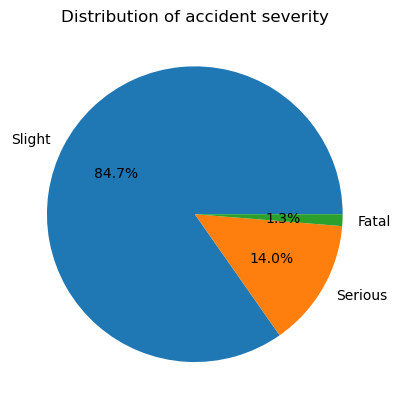

In [13]:
#plotting the the general distribution of accident severity
slight_sum = all.agg(sum('Count of slight accidents')).collect()[0][0]
serious_sum = all.agg(sum('Count of Serious accidents')).collect()[0][0]
fatal_sum = all.agg(sum('Count of Fatal accidents')).collect()[0][0]
sizes = [slight_sum, serious_sum, fatal_sum]
labels = ['Slight', 'Serious', 'Fatal']

fig, ax = plt.subplots()
plt.title("Distribution of accident severity")
ax.pie(sizes, labels=labels, autopct='%1.1f%%')

In [14]:
all_df = all.toPandas()

weekday_mapping = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}

all_df['Day_of_Week_Num'] = all_df['Day_of_Week'].map(weekday_mapping)
df_sorted = all_df.sort_values(by='Day_of_Week_Num')
df_sorted

,Day_of_Week,Count of accidents (All Types),Count of slight accidents,Count of Serious accidents,Count of Fatal accidents,Day_of_Week_Num
5,Monday,290482,248516,38588,3378,0
1,Tuesday,306292,262430,40503,3359,1
0,Wednesday,308580,264532,40683,3365,2
3,Thursday,308240,263357,41376,3507,3
2,Friday,335183,285272,45877,4034,4
4,Saturday,273152,226648,41986,4518,5
6,Sunday,225327,183793,37326,4208,6


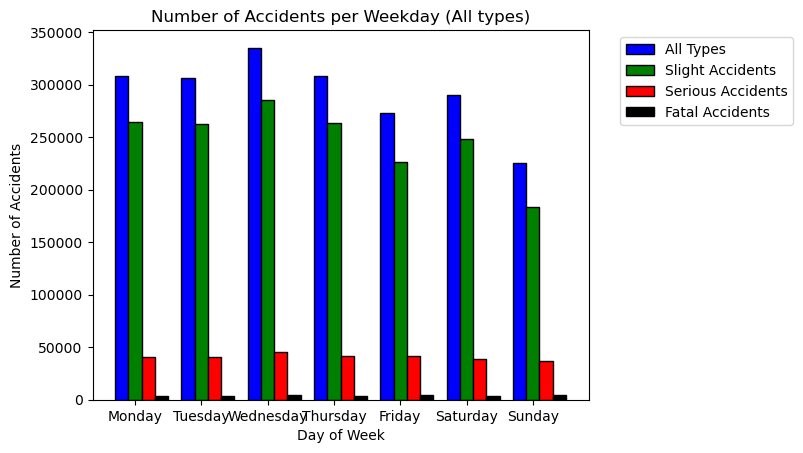

<Figure size 1500x600 with 0 Axes>

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data
r = np.arange(7)
width = 0.2

# Adjusting x-coordinates for the bars
x1 = r - width
x2 = r
x3 = r + width
x4 = r + 2*width

# Plotting the bars
plt.bar(x1, all_df['Count of accidents (All Types)'], color='b', width=width, edgecolor='black', label='All Types')
plt.bar(x2, all_df['Count of slight accidents'], color='g', width=width, edgecolor='black', label='Slight Accidents')
plt.bar(x3, all_df['Count of Serious accidents'], color='r', width=width, edgecolor='black', label='Serious Accidents')
plt.bar(x4, all_df['Count of Fatal accidents'], color='black', width=width, edgecolor='black', label='Fatal Accidents')

# Adding labels and title
plt.xlabel("Day of Week") 
plt.ylabel("Number of Accidents") 
plt.title("Number of Accidents per Weekday (All types)") 

days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.xticks(r, days_of_week)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.figure(figsize=(15,6))
plt.tight_layout()
plt.show()

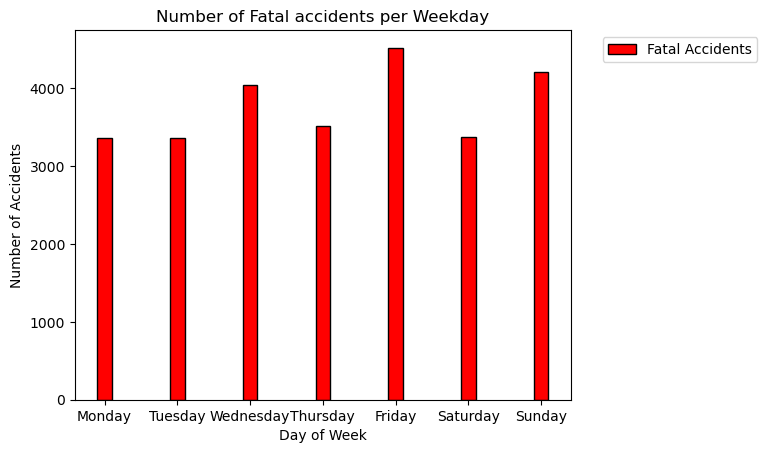

<Figure size 1500x600 with 0 Axes>

In [16]:
# Fatal accidents


plt.bar(x2, all_df['Count of Fatal accidents'], color='r', width=width, edgecolor='black', label='Fatal Accidents')

plt.xlabel("Day of Week") 
plt.ylabel("Number of Accidents") 
plt.title("Number of Fatal accidents per Weekday") 

plt.xticks(r, days_of_week)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.figure(figsize=(15,6))
plt.tight_layout()
plt.show()

### Is The propotion of accident severity different for accidents involving motorcycles ? ¶

In [17]:
#loading the vehicle information dataset
df_vehicles = load_dataframe('../data/car_accidents/Vehicle_information.csv')
df_vehicles.columns

['Accident_Index',
 'Age_Band_of_Driver',
 'Age_of_Vehicle',
 'Driver_Home_Area_Type',
 'Driver_IMD_Decile',
 'Engine_Capacity_.CC.',
 'Hit_Object_in_Carriageway',
 'Hit_Object_off_Carriageway',
 'Journey_Purpose_of_Driver',
 'Junction_Location',
 'make',
 'model',
 'Propulsion_Code',
 'Sex_of_Driver',
 'Skidding_and_Overturning',
 'Towing_and_Articulation',
 'Vehicle_Leaving_Carriageway',
 'Vehicle_Location.Restricted_Lane',
 'Vehicle_Manoeuvre',
 'Vehicle_Reference',
 'Vehicle_Type',
 'Was_Vehicle_Left_Hand_Drive',
 'X1st_Point_of_Impact',
 'Year']

In [18]:
accidents.columns

['Accident_Index',
 'Accident_Severity',
 'Date',
 'Day_of_Week',
 'Latitude',
 'Longitude',
 'Number_of_Casualties',
 'Number_of_Vehicles',
 'Time',
 'Weather_Conditions',
 'Year',
 'Slight',
 'Fatal',
 'Serious']

In [19]:
#joining the accidents dataframe with vehicle information dataset

accidents_vehicles = accidents.join(df_vehicles, accidents["Accident_Index"] == df_vehicles["Accident_Index"], "inner")
accidents_vehicles.count()

2058408

In [20]:
accidents_vehicles.select('Vehicle_Type').distinct().collect()

[Row(Vehicle_Type='Motorcycle - unknown cc'),
 Row(Vehicle_Type='Motorcycle over 500cc'),
 Row(Vehicle_Type='Taxi/Private hire car'),
 Row(Vehicle_Type='Agricultural vehicle'),
 Row(Vehicle_Type='Car'),
 Row(Vehicle_Type='Goods over 3.5t. and under 7.5t'),
 Row(Vehicle_Type='Minibus (8 - 16 passenger seats)'),
 Row(Vehicle_Type='Electric motorcycle'),
 Row(Vehicle_Type='Mobility scooter'),
 Row(Vehicle_Type='Goods vehicle - unknown weight'),
 Row(Vehicle_Type='Motorcycle 125cc and under'),
 Row(Vehicle_Type='Other vehicle'),
 Row(Vehicle_Type='Motorcycle 50cc and under'),
 Row(Vehicle_Type='Ridden horse'),
 Row(Vehicle_Type='Motorcycle over 125cc and up to 500cc'),
 Row(Vehicle_Type='Bus or coach (17 or more pass seats)'),
 Row(Vehicle_Type='Van / Goods 3.5 tonnes mgw or under'),
 Row(Vehicle_Type='Pedal cycle'),
 Row(Vehicle_Type='Data missing or out of range'),
 Row(Vehicle_Type='Goods 7.5 tonnes mgw and over'),
 Row(Vehicle_Type='Tram')]

In [21]:
motorcycles = ['Motorcycle - unknown cc', 'Motorcycle over 500cc', 'Electric motorcycle', 'Motorcycle 125cc and under', 'Motorcycle 50cc and under', 
              'Motorcycle over 125cc and up to 500cc']

moto_seve = accidents_vehicles.filter(col('Vehicle_Type').isin(motorcycles))
                                      
all_moto = moto_seve.groupby('Day_of_Week') \
    .agg(count('Accident_Severity').alias('Count of accidents (All Types)'), \
         sum('Slight').alias('Count of slight accidents'), \
         sum('Serious').alias('Count of Serious accidents'), \
         sum('Fatal').alias('Count of Fatal accidents'))
all_moto.show()

+-----------+------------------------------+-------------------------+--------------------------+------------------------+
|Day_of_Week|Count of accidents (All Types)|Count of slight accidents|Count of Serious accidents|Count of Fatal accidents|
+-----------+------------------------------+-------------------------+--------------------------+------------------------+
|  Wednesday|                         26138|                    19163|                      6509|                     466|
|    Tuesday|                         25759|                    18960|                      6335|                     464|
|     Friday|                         27677|                    20191|                      6981|                     505|
|   Thursday|                         26259|                    19315|                      6465|                     479|
|   Saturday|                         22238|                    14877|                      6695|                     666|
|     Monday|   

([<matplotlib.patches.Wedge at 0x14b71f66850>,
 [Text(-0.6795620341764947, 0.8649829141121256, 'Slight'),
  Text(0.6175831599506745, -0.9102697625129267, 'Serious'),
  Text(1.0973216893460154, -0.07671447119551367, 'Fatal')],
 [Text(-0.37067020045990623, 0.4718088622429775, '71.2%'),
  Text(0.3368635417912769, -0.4965107795525054, '26.6%'),
  Text(0.5985391032796447, -0.04184425701573472, '2.2%')])

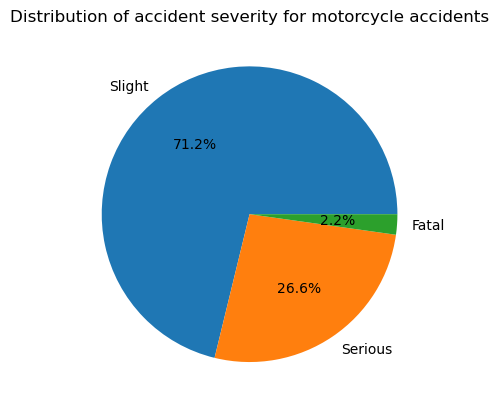

In [22]:
#plotting the the general distribution of accident severity
slight_sum_m = all_moto.agg(sum('Count of slight accidents')).collect()[0][0]
serious_sum_m = all_moto.agg(sum('Count of Serious accidents')).collect()[0][0]
fatal_sum_m = all_moto.agg(sum('Count of Fatal accidents')).collect()[0][0]
sizes = [slight_sum_m, serious_sum_m, fatal_sum_m]
labels = ['Slight', 'Serious', 'Fatal']

fig, ax = plt.subplots()
plt.title("Distribution of accident severity for motorcycle accidents")
ax.pie(sizes, labels=labels, autopct='%1.1f%%')

### Weather 

In [24]:
df.columns

['Accident_Index',
 '1st_Road_Class',
 '1st_Road_Number',
 '2nd_Road_Class',
 '2nd_Road_Number',
 'Accident_Severity',
 'Carriageway_Hazards',
 'Date',
 'Day_of_Week',
 'Did_Police_Officer_Attend_Scene_of_Accident',
 'Junction_Control',
 'Junction_Detail',
 'Latitude',
 'Light_Conditions',
 'Local_Authority_(District)',
 'Local_Authority_(Highway)',
 'Location_Easting_OSGR',
 'Location_Northing_OSGR',
 'Longitude',
 'LSOA_of_Accident_Location',
 'Number_of_Casualties',
 'Number_of_Vehicles',
 'Pedestrian_Crossing-Human_Control',
 'Pedestrian_Crossing-Physical_Facilities',
 'Police_Force',
 'Road_Surface_Conditions',
 'Road_Type',
 'Special_Conditions_at_Site',
 'Speed_limit',
 'Time',
 'Urban_or_Rural_Area',
 'Weather_Conditions',
 'Year',
 'InScotland']

In [53]:
### choosing the columns
columns_weather = ['Accident_Index', 'Accident_Severity', 'Date', 'Light_Conditions', 'Weather_Conditions']
weather_acc = df.select(*columns)
weather_acc.limit(5).toPandas()

,Accident_Index,Accident_Severity,Date,Day_of_Week,Latitude,Longitude,Number_of_Casualties,Number_of_Vehicles,Time,Weather_Conditions,Year
0,200501BS00001,Serious,2005-01-04,Tuesday,51.489096,-0.19117,1,1,17:42,Raining no high winds,2005
1,200501BS00002,Slight,2005-01-05,Wednesday,51.520075,-0.211708,1,1,17:36,Fine no high winds,2005
2,200501BS00003,Slight,2005-01-06,Thursday,51.525301,-0.206458,1,2,00:15,Fine no high winds,2005
3,200501BS00004,Slight,2005-01-07,Friday,51.482442,-0.173862,1,1,10:35,Fine no high winds,2005
4,200501BS00005,Slight,2005-01-10,Monday,51.495752,-0.156618,1,1,21:13,Fine no high winds,2005


### Grouping the number of occured accidents by meteorological seasons in UK

In [54]:
### severity columns
weather_acc = weather_acc \
    .withColumn('Slight', when(col('Accident_Severity') == 'Slight', 1).otherwise(0)) \
    .withColumn('Fatal', when(col('Accident_Severity') == 'Fatal', 1).otherwise(0)) \
    .withColumn('Serious', when(col('Accident_Severity') == 'Serious', 1).otherwise(0)) 
weather_acc.limit(5).toPandas()

,Accident_Index,Accident_Severity,Date,Day_of_Week,Latitude,Longitude,Number_of_Casualties,Number_of_Vehicles,Time,Weather_Conditions,Year,Slight,Fatal,Serious
0,200501BS00001,Serious,2005-01-04,Tuesday,51.489096,-0.19117,1,1,17:42,Raining no high winds,2005,0,0,1
1,200501BS00002,Slight,2005-01-05,Wednesday,51.520075,-0.211708,1,1,17:36,Fine no high winds,2005,1,0,0
2,200501BS00003,Slight,2005-01-06,Thursday,51.525301,-0.206458,1,2,00:15,Fine no high winds,2005,1,0,0
3,200501BS00004,Slight,2005-01-07,Friday,51.482442,-0.173862,1,1,10:35,Fine no high winds,2005,1,0,0
4,200501BS00005,Slight,2005-01-10,Monday,51.495752,-0.156618,1,1,21:13,Fine no high winds,2005,1,0,0


In [55]:
### season columns
spring_condition = ((month(col('Date')) >= 3) & (month(col('Date')) <= 5))
summer_condition = ((month(col('Date')) >= 6) & (month(col('Date')) <= 8))
autumn_condition = ((month(col('Date')) >= 9) & (month(col('Date')) <= 11))
winter_condition = ((month(col('Date')) == 12) | (month(col('Date')) <= 2))

weather_acc = weather_acc \
    .withColumn('Seasons', \
                when(spring_condition, lit("Spring")) \
                .when(summer_condition, lit("Summer")) \
                .when(autumn_condition, lit("Autumn")) \
                .when(winter_condition, lit("Winter")).otherwise(lit("Unknown")))

weather_acc.limit(5).toPandas()

,Accident_Index,Accident_Severity,Date,Day_of_Week,Latitude,Longitude,Number_of_Casualties,Number_of_Vehicles,Time,Weather_Conditions,Year,Slight,Fatal,Serious,Seasons
0,200501BS00001,Serious,2005-01-04,Tuesday,51.489096,-0.19117,1,1,17:42,Raining no high winds,2005,0,0,1,Winter
1,200501BS00002,Slight,2005-01-05,Wednesday,51.520075,-0.211708,1,1,17:36,Fine no high winds,2005,1,0,0,Winter
2,200501BS00003,Slight,2005-01-06,Thursday,51.525301,-0.206458,1,2,00:15,Fine no high winds,2005,1,0,0,Winter
3,200501BS00004,Slight,2005-01-07,Friday,51.482442,-0.173862,1,1,10:35,Fine no high winds,2005,1,0,0,Winter
4,200501BS00005,Slight,2005-01-10,Monday,51.495752,-0.156618,1,1,21:13,Fine no high winds,2005,1,0,0,Winter


In [57]:
#grouping by the season

all_weather = weather_acc.groupby('Seasons') \
    .agg(count('Accident_Severity').alias('Count of accidents (All Types)'), \
         sum('Slight').alias('Count of slight accidents'), \
         sum('Serious').alias('Count of Serious accidents'), \
         sum('Fatal').alias('Count of Fatal accidents'))

all_weather.limit(5).toPandas()


,Seasons,Count of accidents (All Types),Count of slight accidents,Count of Serious accidents,Count of Fatal accidents
0,Spring,494437,418586,69650,6201
1,Summer,520776,437905,76129,6742
2,Autumn,547498,463995,76458,7045
3,Winter,484545,414062,64102,6381


([<matplotlib.patches.Wedge at 0x14b758f0d10>,
 [Text(0.7982794892415812, 0.7568023897003764, 'Spring'),
  Text(-0.7464313197454842, 0.8079853246829517, 'Summer'),
  Text(-0.7549910588037644, -0.7999928131717002, 'Autumn'),
  Text(0.8096751513858372, -0.7445979782596256, 'Winter')],
 [Text(0.4354251759499534, 0.41280130347293253, '24.2%'),
  Text(-0.40714435622480954, 0.44071926800888267, '25.4%'),
  Text(-0.4118133048020533, -0.4363597162754728, '26.7%'),
  Text(0.4416409916650021, -0.40614435177797753, '23.7%')])

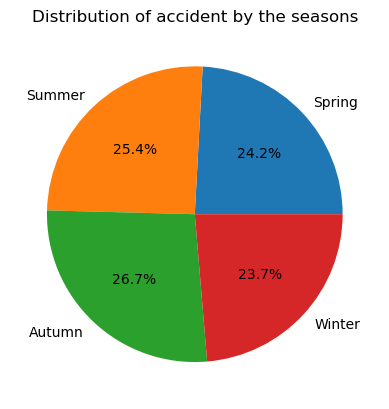

In [73]:
#plotting the count of accidents by the season

spring_sum = all_weather.filter(col('Seasons') =='Spring').select('Count of accidents (All Types)').collect()[0][0]
summer_sum = all_weather.filter(col('Seasons') =='Summer').select('Count of accidents (All Types)').collect()[0][0]
autumn_sum = all_weather.filter(col('Seasons') =='Autumn').select('Count of accidents (All Types)').collect()[0][0]
winter_sum = all_weather.filter(col('Seasons') =='Winter').select('Count of accidents (All Types)').collect()[0][0]

sizes = [spring_sum, summer_sum, autumn_sum, winter_sum]
labels = ['Spring', 'Summer', 'Autumn', 'Winter']

fig, ax = plt.subplots()
plt.title("Distribution of accident by the seasons")
ax.pie(sizes, labels=labels, autopct='%1.1f%%')



### Plotting the accidents and their type on the open street map

In [124]:
import plotly.express as px
import pandas as pd

#Selecting needed columns
df_geo = weather_acc.select(['Accident_Index', 'Longitude', 'Latitude', 'Accident_Severity'])

# creating random sample (for computational reasons )
random_df_geo = df_geo.repartition(1).sortWithinPartitions(rand())
random_df_geo = random_df_geo.limit(2000)

random_df_geo.select('Latitude').show()

+---------+
| Latitude|
+---------+
|52.956106|
| 51.20176|
|55.401144|
|53.154776|
|53.549167|
|53.215643|
|55.938428|
|53.392151|
|50.913379|
|52.273629|
|51.534492|
|53.709819|
|53.580708|
|56.072098|
|53.571704|
|50.965312|
|51.798937|
|53.387467|
|51.115981|
|51.473033|
+---------+
only showing top 20 rows



In [125]:
random_df_geo = random_df_geo.toPandas()
random_df_geo.replace('NA', pd.NA, inplace=True)
random_df_geo = random_df_geo.dropna(subset=['Latitude'])
random_df_geo = random_df_geo.dropna(subset=['Longitude'])

In [126]:

# Map categorical values to numerical values
severity_mapping = {'Low': 1, 'Medium': 2, 'High': 3}  # Example mapping, adjust as needed
random_df_geo['Accident_Severity_Numeric'] = random_df_geo['Accident_Severity'].map(severity_mapping)

random_df_geo['Latitude'] = random_df_geo['Latitude'].astype(float)
random_df_geo['Longitude'] = random_df_geo['Longitude'].astype(float)

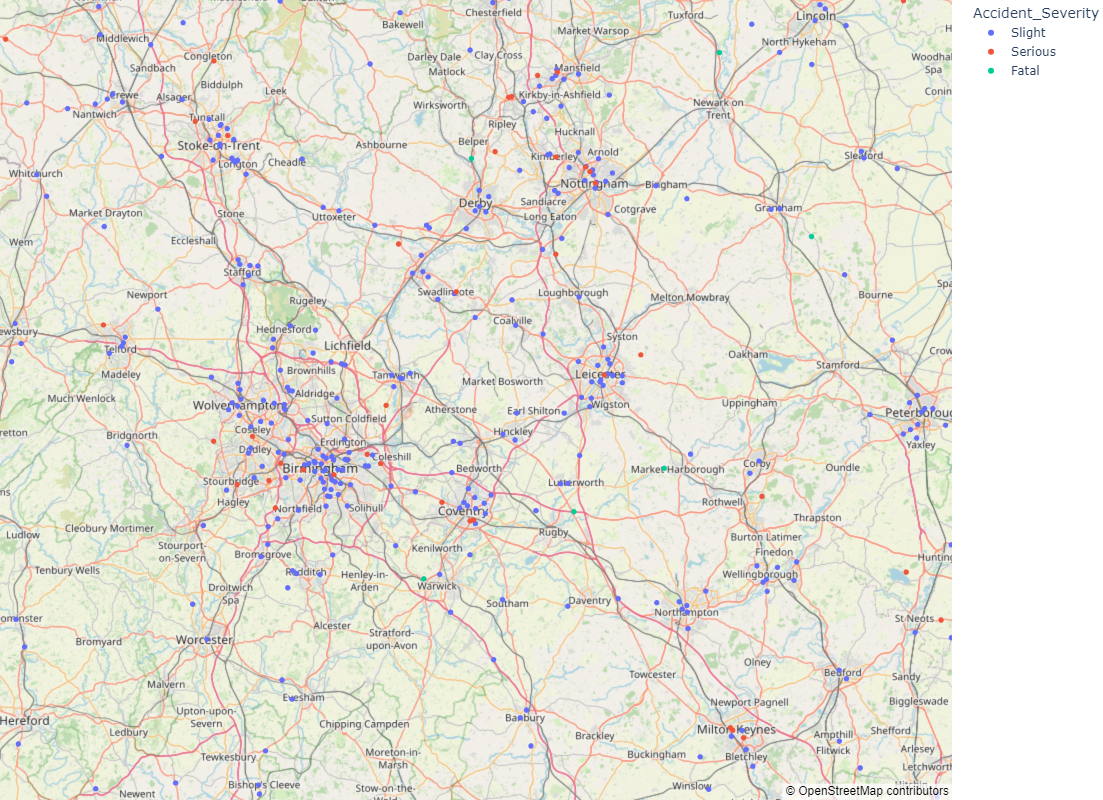

In [127]:
fig = px.scatter_mapbox(random_df_geo, 
                        lat="Latitude", 
                        lon="Longitude", 
                        hover_name="Accident_Index", 
                        hover_data=["Accident_Index", "Accident_Severity"],
                        color="Accident_Severity",
                        zoom=8, 
                        height=800,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()
